In [1]:
# Librerias
import pandas as pd
import yfinance as yf
from ta.trend import wma_indicator
from ta.trend import sma_indicator

import matplotlib.pyplot as plt
import matplotlib as mpl
import math
from ta.volatility import BollingerBands
import numpy as np
import mplfinance as mplf

In [2]:
# Toma de datos
stock_data = pd.DataFrame() 
stock_start_date = '2021-04-01'
stock_end_date   = '2023-06-11' 

data = yf.download('HMY', start=stock_start_date, end=stock_end_date) 

[*********************100%***********************]  1 of 1 completed


In [3]:
# Acá comienza la fiesta
feat = data.ffill().copy(deep=True)

In [4]:
# Canal de Kelner
kc_len = 60
feat['keltner'] = wma_indicator(2 * wma_indicator(feat['Close'], window=kc_len//2) - wma_indicator(feat['Close'], window=kc_len), round(math.sqrt(kc_len)))
feat['keltner_bull'] = np.where(feat['keltner'] < feat['Close'], feat['keltner'], np.nan)
feat['keltner_bear'] = np.where(feat['keltner'] >= feat['Close'], feat['keltner'], np.nan)

# Unir las lineas
feat['keltner_bull'] = np.where((feat['keltner_bull'].shift(-1).notna() & feat['keltner_bull'].isna()), feat['keltner'], feat['keltner_bull'])
feat['keltner_bear'] = np.where((feat['keltner_bear'].shift(-1).notna() & feat['keltner_bear'].isna()), feat['keltner'], feat['keltner_bear'])

In [5]:
# Bandas de bollinger

# Lenta
feat['bb_lh2'] = BollingerBands(feat['Close'], window=84, window_dev=2, fillna=True).bollinger_hband()
feat['bb_ll2'] = BollingerBands(feat['Close'], window=84, window_dev=2, fillna=True).bollinger_lband()
feat['bb_lh1'] = BollingerBands(feat['Close'], window=84, window_dev=1, fillna=True).bollinger_hband()
feat['bb_ll1'] = BollingerBands(feat['Close'], window=84, window_dev=1, fillna=True).bollinger_lband()

# Rapida
feat['bb_sh2'] = BollingerBands(feat['Close'], window=20, window_dev=2, fillna=True).bollinger_hband()
feat['bb_sl2'] = BollingerBands(feat['Close'], window=20, window_dev=2, fillna=True).bollinger_lband()
feat['bb_sh1'] = BollingerBands(feat['Close'], window=20, window_dev=1, fillna=True).bollinger_hband()
feat['bb_sl1'] = BollingerBands(feat['Close'], window=20, window_dev=1, fillna=True).bollinger_lband()

In [6]:
# SMA 200
feat['mm200'] = sma_indicator(feat['Close'], window=200, fillna=True)

In [7]:
# Variables Algoritmo de Laguerre + PPO
lg_Short = 0.4
lg_Long = 0.8
lg_lkb = 200
lg_pctile = 90
lg_wrnpctile = 70

In [8]:
# Rutina para Laguerre
def laguerre(g: float, p: pd.Series):

    L0 = pd.Series(0, index = p.index)
    L1 = pd.Series(0, index = p.index)
    L2 = pd.Series(0, index = p.index)
    L3 = pd.Series(0, index = p.index)

    for i in range(1, p.size):

        p_L0 = L0.iloc[i - 1]
        p_L1 = L1.iloc[i - 1]
        p_L2 = L2.iloc[i - 1]
        p_L3 = L3.iloc[i - 1]

        L0.iloc[i] = ( 1 - g ) * p[i] + g * p_L0
        L1.iloc[i] = -g * L0[i] + p_L0 + g * p_L1
        L2.iloc[i] = -g * L1.iloc[i] + p_L1 + g * p_L2
        L3.iloc[i] = -g * L2.iloc[i] + p_L2 + g * p_L3
    
    return ( L0 + 2 * L1 + 2 * L2 + L3 ) / 6

def pRank(src):
    # Número de velas anteriores superiores a la vela actual
    return (len([x for x in src[::-1][1:] if src[-1] >= x]) / (len(src)-1))

In [9]:
hl2 = ((feat['High'] + feat['Low']) / 2 )

lg_lmas = laguerre(lg_Short, hl2)
lg_lmal = laguerre(lg_Long, hl2)

lg_pctileB = lg_pctile * -1
lg_wrnpctileB = lg_wrnpctile * -1

#PPO Plot
lg_ppoT = (lg_lmas - lg_lmal) / lg_lmal * 100
lg_ppoB = (lg_lmal - lg_lmas) / lg_lmal * 100

feat['lg_pctRankT'] = lg_ppoT.rolling(lg_lkb+1).apply(pRank)
feat['lg_pctRankB'] = lg_ppoB.rolling(lg_lkb+1).apply(pRank)

In [10]:
# Restrinjo datos a mostrar
feat = feat['2022-10-01':]
#feat[['lg_pctRankT', 'lg_pctRankB']].fillna(value=0, inplace=True)

cm_greens = mpl.colormaps.get_cmap('Greens')
cm_reds = mpl.colormaps.get_cmap('Reds')
normalize = mpl.colors.Normalize(vmin=0, vmax=1)

#fb_lh = dict(y1=feat['bb_lh1'].values, y2=feat['bb_lh2'].values, panel=0, alpha=1, color=cm_reds(normalize(feat['lg_pctRankT'])))
#fb_sh = dict(y1=feat['bb_sh1'].values, y2=feat['bb_sh2'].values, panel=0, alpha=1, color=cm_reds(normalize(feat['lg_pctRankB'])))
#fb_ll = dict(y1=feat['bb_ll1'].values, y2=feat['bb_ll2'].values, panel=0, alpha=1, color=cm_greens(normalize(feat['lg_pctRankT'])))
#fb_sl = dict(y1=feat['bb_sl1'].values, y2=feat['bb_sl2'].values, panel=0, alpha=1, color=cm_greens(normalize(feat['lg_pctRankB'])))
#
#fb_lh = dict(y1=feat['bb_lh1'].values, y2=feat['bb_lh2'].values, panel=0, color=cm_reds(0.5))
#fb_sh = dict(y1=feat['bb_sh1'].values, y2=feat['bb_sh2'].values, panel=0, alpha=1, color='red')
#fb_ll = dict(y1=feat['bb_ll1'].values, y2=feat['bb_ll2'].values, panel=0, alpha=1, color='green')
#fb_sl = dict(y1=feat['bb_sl1'].values, y2=feat['bb_sl2'].values, panel=0, alpha=1, color='green')
#

In [11]:
(feat['lg_pctRankT'].iloc[0]), (math.isnan(feat['lg_pctRankT'].iloc[0]))

(0.15, False)

In [12]:
fb_lh = []
fb_sh = []
fb_ll = []
fb_sl = []
for i in range(0, feat.shape[0]-2):
    if math.isnan(feat['lg_pctRankT'].iloc[i]):
        fb_lh = fb_lh + [dict(y1=np.asarray([feat['bb_lh1'].iloc[i], feat['bb_lh1'].iloc[i+1]]),
                              y2=np.asarray([feat['bb_lh2'].iloc[i], feat['bb_lh2'].iloc[i+1]]),
                              alpha=0.0,
                              panel=0,
                              color='r')]
    else:
        fb_lh = fb_lh + [dict(y1=np.asarray([feat['bb_lh1'].iloc[i], feat['bb_lh1'].iloc[i+1]]),
                              y2=np.asarray([feat['bb_lh2'].iloc[i], feat['bb_lh2'].iloc[i+1]]),
                              alpha=feat['lg_pctRankT'].iloc[i]/2,
                              panel=0,
                              color='r')]
    if math.isnan(feat['lg_pctRankB'].iloc[i]):
        fb_sh = fb_sh + [dict(y1=np.asarray([feat['bb_sh1'].iloc[i], feat['bb_sh1'].iloc[i+1]]),
                              y2=np.asarray([feat['bb_sh2'].iloc[i], feat['bb_sh2'].iloc[i+1]]),
                              alpha=0.0,
                              panel=0,
                              color='r')]
    else:
        fb_sh = fb_sh + [dict(y1=np.asarray([feat['bb_sh1'].iloc[i], feat['bb_sh1'].iloc[i+1]]),
                              y2=np.asarray([feat['bb_sh2'].iloc[i], feat['bb_sh2'].iloc[i+1]]),
                              alpha=feat['lg_pctRankB'].iloc[i]/2,
                              panel=0,
                              color='r')]
    if math.isnan(feat['lg_pctRankT'].iloc[i]):
        fb_ll = fb_ll + [dict(y1=np.asarray([feat['bb_ll1'].iloc[i], feat['bb_ll1'].iloc[i+1]]),
                              y2=np.asarray([feat['bb_ll2'].iloc[i], feat['bb_ll2'].iloc[i+1]]),
                              alpha=0,
                              panel=0,
                              color='g')]
    else:
        fb_ll = fb_ll + [dict(y1=np.asarray([feat['bb_ll1'].iloc[i], feat['bb_ll1'].iloc[i+1]]),
                              y2=np.asarray([feat['bb_ll2'].iloc[i], feat['bb_ll2'].iloc[i+1]]),
                              alpha=feat['lg_pctRankT'].iloc[i]/2,
                              panel=0,
                              color='g')]
    if math.isnan(feat['lg_pctRankB'].iloc[i]):
        fb_sl = fb_sl + [dict(y1=np.asarray([feat['bb_sl1'].iloc[i], feat['bb_sl1'].iloc[i+1]]),
                              y2=np.asarray([feat['bb_sl2'].iloc[i], feat['bb_sl2'].iloc[i+1]]),
                              alpha=0,
                              panel=0,
                              color='g')]
    else:
        fb_sl = fb_sl + [dict(y1=np.asarray([feat['bb_sl1'].iloc[i], feat['bb_sl1'].iloc[i+1]]),
                              y2=np.asarray([feat['bb_sl2'].iloc[i], feat['bb_sl2'].iloc[i+1]]),
                              alpha=feat['lg_pctRankB'].iloc[i]/2,
                              panel=0,
                              color='g')]

In [13]:
fb_lh_b = dict(y1=feat['bb_lh1'].values,
               y2=feat['bb_lh2'].values,
               alpha=0.2,
               panel=0,
               where=feat['lg_pctRankT']>=0.8,
               color='r',
               interpolate=True)
fb_lh_l = fb_lh_b.copy()
fb_lh_l['alpha'] = 0.05
fb_lh_l['where'] = feat['lg_pctRankT']<0.8

fb_sh_b = dict(y1=feat['bb_sh1'].values,
               y2=feat['bb_sh2'].values,
               alpha=0.2,
               panel=0,
               where=feat['lg_pctRankB']>=0.8,
               color='r',
               interpolate=True)
fb_sh_l = fb_sh_b.copy()
fb_sh_l['alpha'] = 0.05
fb_sh_l['where'] = feat['lg_pctRankB']<0.8

fb_ll_b = dict(y1=feat['bb_ll1'].values,
               y2=feat['bb_ll2'].values,
               alpha=0.2,
               panel=0,
               where=feat['lg_pctRankT']>=0.8,
               color='g',
               interpolate=True)
fb_ll_l = fb_ll_b.copy()
fb_ll_l['alpha'] = 0.05
fb_ll_l['where'] = feat['lg_pctRankT']<0.8

fb_sl_b = dict(y1=feat['bb_sl1'].values,
               y2=feat['bb_sl2'].values,
               alpha=0.2,
               panel=0,
               where=feat['lg_pctRankB']>=0.8,
               color='g',
               interpolate=True)
fb_sl_l = fb_sl_b.copy()
fb_sl_l['alpha'] = 0.05
fb_sl_l['where'] = feat['lg_pctRankB']<0.8


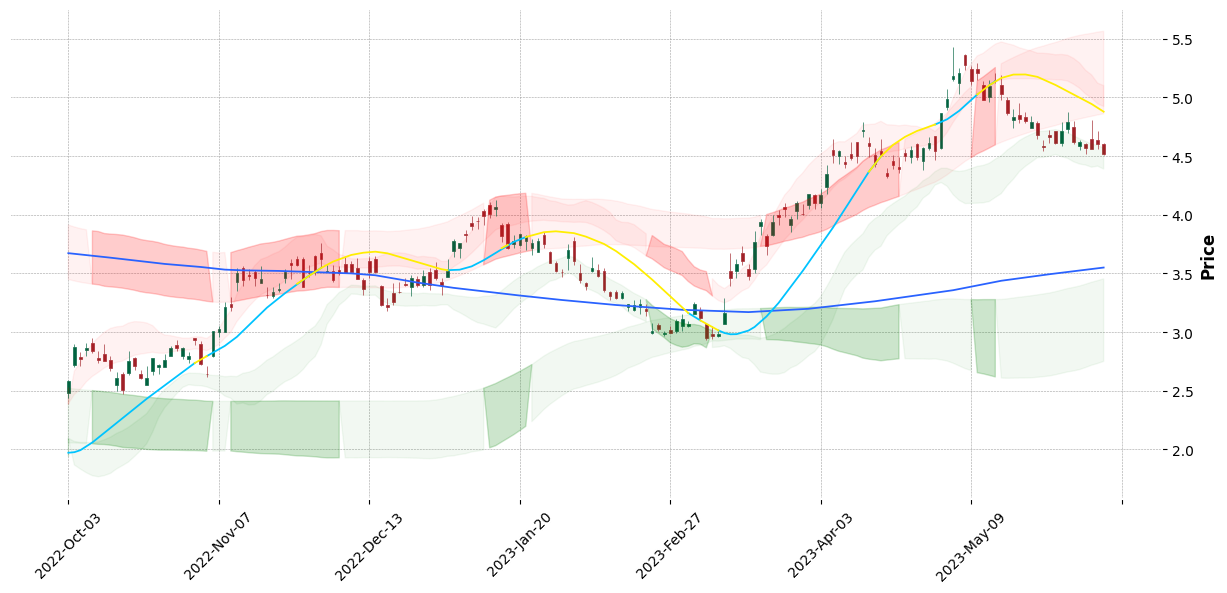

In [14]:
# Grafico

apd = [mplf.make_addplot(feat['mm200'], color='#2962ff', linewidths=4),
       mplf.make_addplot(feat['keltner_bull'], color='#00c3ff', linewidths=2),
       mplf.make_addplot(feat['keltner_bear'], color='#ffee00', linewidths=2)]

mplf.plot(feat,
         type="candle",
         style='charles',
         volume=False,
         figsize=(16, 7),
         fill_between=[fb_lh_b, fb_lh_l,
                       fb_sh_b, fb_sh_l,
                       fb_ll_b, fb_ll_l,
                       fb_sl_b, fb_sl_l],
         addplot=apd)

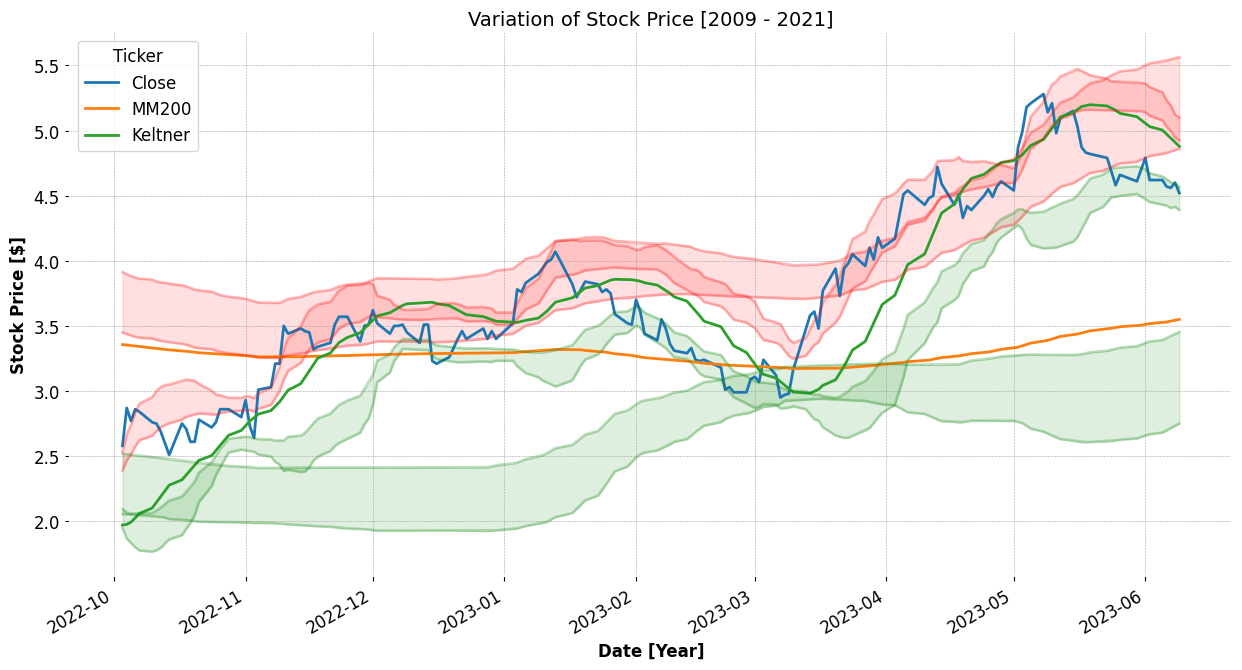

In [17]:
feat['Close'].plot(kind='line', figsize=(15, 8),  fontsize=12)
feat['mm200'].plot(label='MM200')
feat['keltner'].plot(label='Keltner')

feat['bb_lh2'].plot(kind='line', color='red', alpha=0.25, label='')
feat['bb_lh1'].plot(kind='line', color='red', alpha=0.25, label='')
feat['bb_ll2'].plot(kind='line', color='green', alpha=0.25, label='')
feat['bb_ll1'].plot(kind='line', color='green', alpha=0.25, label='')

plt.fill_between(feat.index, feat['bb_lh1'], feat['bb_lh2'], color='red', alpha=.125)
plt.fill_between(feat.index, feat['bb_ll1'], feat['bb_ll2'], color='green', alpha=.125)

feat['bb_sh2'].plot(kind='line', color='red', alpha=0.25, label='')
feat['bb_sh1'].plot(kind='line', color='red', alpha=0.25, label='')
feat['bb_sl2'].plot(kind='line', color='green', alpha=0.25, label='')
feat['bb_sl1'].plot(kind='line', color='green', alpha=0.25, label='')

plt.fill_between(feat.index, feat['bb_sh1'], feat['bb_sh2'], color='red', alpha=.125)
plt.fill_between(feat.index, feat['bb_sl1'], feat['bb_sl2'], color='green', alpha=.125)

plt.xlabel('Date [Year]', fontsize=12)
plt.ylabel('Stock Price [$]', fontsize=12)
plt.legend(loc='best', fontsize=12,title='Ticker', title_fontsize='12')
plt.title('Variation of Stock Price [2009 - 2021]', fontsize=14)
plt.show()

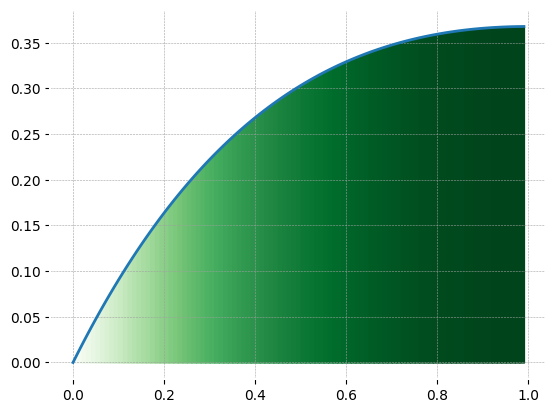

In [161]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

colourmap = mpl.colormaps.get_cmap('Greens')

xx = np.arange(0, 1, 0.01)
yy = xx*np.exp(-xx)

plt.plot(xx,yy)
normalize = mpl.colors.Normalize(vmin=yy.min(), vmax=yy.max())
npts = 100
for i in range(npts - 1):
    plt.fill_between([xx[i], xx[i+1]],
                     [yy[i], yy[i+1]],
                     color=colourmap(normalize(yy[i]))
                     ,alpha=1)
plt.show()